In [1]:
import os
import pybedtools
import pandas as pd
import numpy as np
import glob
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import random
from Bio import SeqIO
from Bio.Seq import Seq
import pysam

In [2]:
custom_palette = ['#C8ADC0', '#FE9920', '#028090', '#151E3F', '#7E1F86','#F27D18']

In [3]:
sns_palette = sns.color_palette(custom_palette)

In [4]:
sns_palette

[(0.7843137254901961, 0.6784313725490196, 0.7529411764705882),
 (0.996078431372549, 0.6, 0.12549019607843137),
 (0.00784313725490196, 0.5019607843137255, 0.5647058823529412),
 (0.08235294117647059, 0.11764705882352941, 0.24705882352941178),
 (0.49411764705882355, 0.12156862745098039, 0.5254901960784314),
 (0.9490196078431372, 0.49019607843137253, 0.09411764705882353)]

In [5]:
sns.set_palette(sns_palette)

In [6]:
working_dir = '/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline'

In [7]:
sample_dict_wt = {'rep1' : '231_NT_rep1', 
               'rep2' : '231_NT_rep2'}
sample_dict_cocl2 = {'rep1' : '231_cocl2_rep1',
               'rep2' : '231_cocl2_rep2'}

In [8]:
output_dir = '/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline'

In [9]:
gtf_file = "/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/refs/hg38/gencode.v38.annotation.gtf" # Replace with your GTF file path

## Get counts data and gene and isoform features for downstream analysis 

In [10]:
total_mapped_reads = {}
for keys in ['rep1', 'rep2']:
    total_mapped_reads[sample_dict_wt[keys]] = int(pysam.view("-c", os.path.join(working_dir, f'{sample_dict_wt[keys]}/input_dir/{sample_dict_wt[keys]}.flnc.aligned.readfiltered.sorted.bam')).strip('\n'))
    total_mapped_reads[sample_dict_cocl2[keys]] = int(pysam.view("-c", os.path.join(working_dir, f'{sample_dict_cocl2[keys]}/input_dir/{sample_dict_cocl2[keys]}.flnc.aligned.readfiltered.sorted.bam')).strip('\n'))

In [11]:
# store gene characteristics from GTF
gtf_len_df = pd.read_csv(gtf_file, sep='\t', header=None, comment='#')
gtf_len_df = gtf_len_df[gtf_len_df[2] == 'gene']
gtf_len_df['gene_length'] = gtf_len_df[4] - gtf_len_df[3] + 1
gtf_len_df['gene_id'] = gtf_len_df[8].str.extract('gene_id "([^"]+)"')
gene_length_dict = gtf_len_df.set_index('gene_id')['gene_length'].to_dict()
gtf_len_df['gene_name'] = gtf_len_df[8].str.extract('gene_name "([^"]+)"')
gene_name_length_dict = gtf_len_df.set_index('gene_name')['gene_length'].to_dict()
gene_id_to_name_dict = gtf_len_df.set_index('gene_id')['gene_name'].to_dict()

In [13]:
# store isoform characteristics from GTF
gtf_transcript_to_gene_df = pd.read_csv(gtf_file, sep='\t', header=None, comment='#')
gtf_transcript_to_gene_df = gtf_transcript_to_gene_df[gtf_transcript_to_gene_df[2] == 'transcript']
gtf_transcript_to_gene_df['gene_id'] = gtf_transcript_to_gene_df[8].str.extract('gene_id "([^"]+)"')
gtf_transcript_to_gene_df['transcript_id'] = gtf_transcript_to_gene_df[8].str.extract('transcript_id "([^"]+)"')
gtf_transcript_to_gene_df['transcript_length'] = gtf_transcript_to_gene_df[4] - gtf_transcript_to_gene_df[3]
gtf_transcript_to_gene_dict = dict(zip(gtf_transcript_to_gene_df.transcript_id, gtf_transcript_to_gene_df.gene_id))
gtf_transcript_to_length_dict = dict(zip(gtf_transcript_to_gene_df.transcript_id, gtf_transcript_to_gene_df.transcript_length))

In [14]:
# Store isoform counts and calculate RPKM (expression)
transcript_counts={}
for rep in ['rep1', 'rep2']:
    for sample_dict in [sample_dict_wt, sample_dict_cocl2]:
        transcript_counts_table = pd.read_csv(f'/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/{sample_dict[rep]}/output_dir/{sample_dict[rep]}_isoquant/{sample_dict[rep]}/{sample_dict[rep]}.transcript_counts.tsv', comment='#', sep='\t', header=None)
        transcript_counts_table = transcript_counts_table.rename(columns={0:'transcript_id', 1: f'{sample_dict[rep]}_count'})
        transcript_counts_table['Length'] = transcript_counts_table.transcript_id.map(gtf_transcript_to_length_dict)
        transcript_counts_table = transcript_counts_table[transcript_counts_table[f'{sample_dict[rep]}_count'] >=20]
        transcript_counts_table[f'{sample_dict[rep]}_RPKM'] = transcript_counts_table.apply(lambda x: (x[f'{sample_dict[rep]}_count'])/((transcript_counts_table[f'{sample_dict[rep]}_count'].sum()/1000000.)*(x['Length']/1000.)), axis=1)
        transcript_counts[f'{sample_dict[rep]}'] = transcript_counts_table.set_index('transcript_id')

In [15]:
# Store gene counts and calculate RPKM (expression)
gene_counts = {}
for key in transcript_counts:
    gene_count_df=transcript_counts[key].copy()
    gene_count_df['gene_id'] = gene_count_df.index.map(gtf_transcript_to_gene_dict)
    gene_count_df = gene_count_df[[f'{key}_count', 'gene_id']].groupby('gene_id').sum()
    gene_count_df = gene_count_df.rename(columns={f'{key}_count' : f'{key}'})
    gene_count_df['Length'] = gene_count_df.index.map(gene_length_dict)
    gene_count_df[f'{key}_RPKM'] = gene_count_df.apply(lambda x: (x[f'{key}'])/((gene_count_df[f'{key}'].sum()/1000000.)*(x['Length']/1000.)), axis=1)
    gene_count_df = gene_count_df[gene_count_df[key] >=20]
    gene_count_df = gene_count_df.reset_index().rename(columns={'gene_id' : 'Geneid'})

    gene_counts[key] = gene_count_df

In [16]:
# create matrix from gene counts to run differential expression with DESeq2
deseq2_gene_count_matrix = pd.DataFrame()
for key in sorted(gene_counts):
    deseq2_gene_count_matrix = pd.concat([deseq2_gene_count_matrix, gene_counts[key][['Geneid', key]].set_index('Geneid')], axis=1)
deseq2_gene_count_matrix = deseq2_gene_count_matrix.dropna()

In [17]:
#deseq2_gene_count_matrix.to_csv('all_sample_counts_matrix_gene_isoquant.csv')

In [18]:
expressed_genes = list(deseq2_gene_count_matrix.index.map(gene_id_to_name_dict))

## Concatenate and filter edits

#### Get Read Level Edits

In [19]:
def concat_splits_all_edits(sample_dict):
    '''concatenate all position level edits from all splits and reps and store as dictionary'''
    concat_edits = {}
    for key in sample_dict:
        print(key)
        read_level_edits_df = pd.DataFrame()
        empty_splits = []
        for p in tqdm.tqdm(glob.glob(os.path.join(working_dir, f'{sample_dict[key]}/output_dir/read_level_edits_ct/*edits_*.bed'))):
            if os.path.getsize(p) != 0:
                edit_df = pd.read_csv(p, sep='\t', header=None)
                edit_df['split_label'] =  p.split('/')[-1].split('_read_level_edits')[0]
                edit_df['key'] = edit_df.apply(lambda x: f'{x[0]}:{str(x[1])}:{str(x[2])}', axis=1)
                edit_df['location'] = p.split('/')[-1].split('.bed')[0].split('edits_')[-1]
                edit_df = edit_df[edit_df['location']=='CDS'] #### ONLY KEEPING CDS
                read_level_edits_df = pd.concat([read_level_edits_df, edit_df])
            else:
                empty_splits.append(p.split('/')[-1])
        
        print(' '.join(empty_splits))
        concat_edits[key] = read_level_edits_df
        
    return concat_edits

In [20]:
concat_edits_wt = concat_splits_all_edits(sample_dict_wt)

rep1


100%|██████████| 777/777 [00:32<00:00, 24.12it/s]


split_bam_21_0_read_level_edits_3utr.bed split_bam_16_0_read_level_edits_5utr.bed split_bam_19_0_read_level_edits_5utr.bed split_bam_20_0_read_level_edits_3utr.bed split_bam_20_0_read_level_edits_5utr.bed split_bam_20_0_read_level_edits_CDS.bed split_bam_21_0_read_level_edits_5utr.bed split_bam_17_0_read_level_edits_5utr.bed split_bam_21_0_read_level_edits_CDS.bed
rep2


100%|██████████| 777/777 [00:33<00:00, 23.45it/s]

split_bam_2_40_read_level_edits_5utr.bed split_bam_17_0_read_level_edits_5utr.bed


In [21]:
concat_edits_cocl2 = concat_splits_all_edits(sample_dict_cocl2)

rep1


100%|██████████| 759/759 [00:38<00:00, 19.86it/s]


split_bam_21_0_read_level_edits_3utr.bed split_bam_19_0_read_level_edits_5utr.bed split_bam_22_0_read_level_edits_3utr.bed split_bam_22_0_read_level_edits_5utr.bed split_bam_22_0_read_level_edits_CDS.bed split_bam_21_0_read_level_edits_5utr.bed split_bam_18_0_read_level_edits_5utr.bed split_bam_21_0_read_level_edits_CDS.bed
rep2


100%|██████████| 744/744 [00:32<00:00, 22.83it/s]

split_bam_21_0_read_level_edits_3utr.bed split_bam_16_0_read_level_edits_CDS.bed split_bam_16_0_read_level_edits_5utr.bed split_bam_19_0_read_level_edits_5utr.bed split_bam_15_0_read_level_edits_5utr.bed split_bam_19_0_read_level_edits_3utr.bed split_bam_22_0_read_level_edits_3utr.bed split_bam_22_0_read_level_edits_5utr.bed split_bam_22_0_read_level_edits_CDS.bed split_bam_23_0_read_level_edits_5utr.bed split_bam_21_0_read_level_edits_5utr.bed split_bam_21_0_read_level_edits_CDS.bed


#### Get position level edits

In [22]:
def concat_splits_all_pos_edits(sample_dict):
    all_sample_pos_edits = {}
    for key in sample_dict:
        print(key)
        all_pos_edits_df = pd.DataFrame()
        empty_splits = []
        bed_files = [i for i in glob.glob(os.path.join(working_dir, f'{sample_dict[key]}/output_dir/*_ct_*.bed')) if '_transcript' not in i]
        for p in tqdm.tqdm(bed_files):
            if '_transcript' not in p:
                if os.path.getsize(p) != 0:
                    split_pos_edit_df = pd.read_csv(p, sep='\t', header=None)
                    split_pos_edit_df['split_label'] =  p.split('/')[-1].split('_ct_')[0]
                    split_pos_edit_df['key'] = split_pos_edit_df.apply(lambda x: f'{x[0]}:{str(x[1])}:{str(x[2])}', axis=1)
                    split_pos_edit_df['location'] = p.split('/')[-1].split('.bed')[0].split('_ct_')[-1]
                    split_pos_edit_df['conversion'] = split_pos_edit_df.apply(lambda x: int(x[4].split(',')[0]), axis=1)
                    split_pos_edit_df['coverage'] = split_pos_edit_df.apply(lambda x: int(x[4].split(',')[1]), axis=1)
                    split_pos_edit_df['edit_fraction'] = split_pos_edit_df.apply(lambda x: x['conversion']/x['coverage'], axis=1)
                    split_pos_edit_df = split_pos_edit_df[split_pos_edit_df['location']=='CDS']#### ONLY KEEPING CDS EDITS
                    all_pos_edits_df = pd.concat([all_pos_edits_df, split_pos_edit_df])
                else:
                    empty_splits.append(p.split('/')[-1])

        print(' '.join(empty_splits))
        all_sample_pos_edits[key] = all_pos_edits_df
        
    return all_sample_pos_edits

In [23]:
all_pos_edits_wt = concat_splits_all_pos_edits(sample_dict_wt)

rep1


100%|██████████| 777/777 [00:28<00:00, 27.27it/s]


split_bam_19_0_ct_5utr.bed split_bam_20_0_ct_5utr.bed split_bam_21_0_ct_5utr.bed split_bam_21_0_ct_3utr.bed split_bam_16_0_ct_5utr.bed split_bam_20_0_ct_3utr.bed split_bam_21_0_ct_CDS.bed split_bam_20_0_ct_CDS.bed split_bam_17_0_ct_5utr.bed
rep2


100%|██████████| 777/777 [00:27<00:00, 28.44it/s]

split_bam_2_40_ct_5utr.bed split_bam_17_0_ct_5utr.bed


In [24]:
all_pos_edits_cocl2 = concat_splits_all_pos_edits(sample_dict_cocl2)

rep1


100%|██████████| 753/753 [00:27<00:00, 27.11it/s]


split_bam_19_0_ct_5utr.bed split_bam_18_0_ct_5utr.bed
rep2


100%|██████████| 743/743 [00:25<00:00, 29.13it/s]

split_bam_19_0_ct_5utr.bed split_bam_15_0_ct_5utr.bed split_bam_22_0_ct_CDS.bed split_bam_16_0_ct_CDS.bed split_bam_22_0_ct_5utr.bed split_bam_22_0_ct_3utr.bed split_bam_21_0_ct_5utr.bed split_bam_21_0_ct_3utr.bed split_bam_23_0_ct_5utr.bed split_bam_21_0_ct_CDS.bed split_bam_19_0_ct_3utr.bed


In [25]:
common_wt_sites = set(all_pos_edits_wt['rep1']['key'].tolist()).intersection(set(all_pos_edits_wt['rep2']['key'].tolist())) # get sites common to no treatment (WT) replicates

In [26]:
common_cocl2_sites = set(all_pos_edits_cocl2['rep1']['key'].tolist()).intersection(set(all_pos_edits_cocl2['rep2']['key'].tolist())) # get sites common to CoCl2 replicates

In [27]:
common_wt_cocl2_sites = common_wt_sites.intersection(common_cocl2_sites) # get sites common across replicates of no treatment and CoCl2

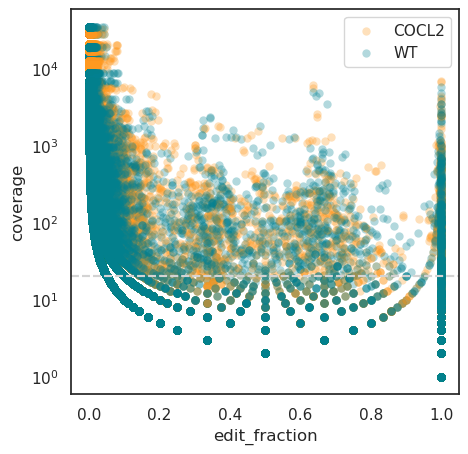

In [28]:
# Visualize Coverage vs. Edit fraction for edited sites found in no treatment and Cocl2 samples
sns.set(rc={'figure.figsize':(5,5)})
sns.set_style('white')

for rep in ['rep1', 'rep2']:
    sns.scatterplot(data=all_pos_edits_cocl2[rep], x='edit_fraction', y='coverage', alpha=0.3, linewidth=0, color='#FE9920')
    sns.scatterplot(data=all_pos_edits_wt[rep], x='edit_fraction', y='coverage', alpha=0.3, linewidth=0, color='#028090')
    
    plt.yscale('log')
    plt.legend(['COCL2', 'WT'])
    plt.axhline(y=20, color='lightgrey', linestyle='dashed')
plt.show()

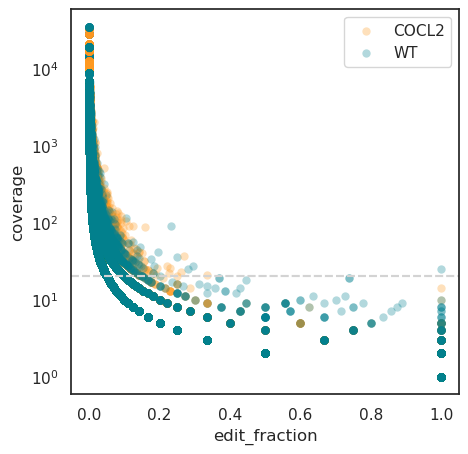

In [29]:
# Visualize Coverage vs. Edit fraction for edited sites found in no treatment and Cocl2 samples after removing common sites
for rep in ['rep1', 'rep2']:
    sns.scatterplot(data=all_pos_edits_cocl2[rep][~all_pos_edits_cocl2[rep]['key'].isin(common_wt_cocl2_sites)], x='edit_fraction', y='coverage', alpha=0.3, linewidth=0, color='#FE9920')
    sns.scatterplot(data=all_pos_edits_wt[rep][~all_pos_edits_wt[rep]['key'].isin(common_wt_cocl2_sites)], x='edit_fraction', y='coverage', alpha=0.3, linewidth=0, color='#028090')
    
    plt.yscale('log')
    plt.legend(['COCL2', 'WT'])
    plt.axhline(y=20, color='lightgrey', linestyle='dashed')
plt.show()

In [30]:
# store edited positions after removing common sites
all_pos_edits_wt_common_removed = {}
all_pos_edits_cocl2_common_removed = {}
for rep in ['rep1', 'rep2']:
    all_pos_edits_wt_common_removed[rep] = all_pos_edits_wt[rep][~all_pos_edits_wt[rep]['key'].isin(common_wt_cocl2_sites)]
    all_pos_edits_cocl2_common_removed[rep] = all_pos_edits_cocl2[rep][~all_pos_edits_cocl2[rep]['key'].isin(common_wt_cocl2_sites)]

In [31]:
# load annotated SNP sites
snps = pd.read_csv('/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/refs/hg38/b151_GRCh38p7_common.with_chr.bed3', sep='\t', header=None)

In [32]:
snps['key'] = snps.apply(lambda x: f'{x[0]}:{str(x[1])}:{str(x[2])}', axis=1)
snps['length'] = snps[2] - snps[1]
snps_list = snps['key'].tolist()

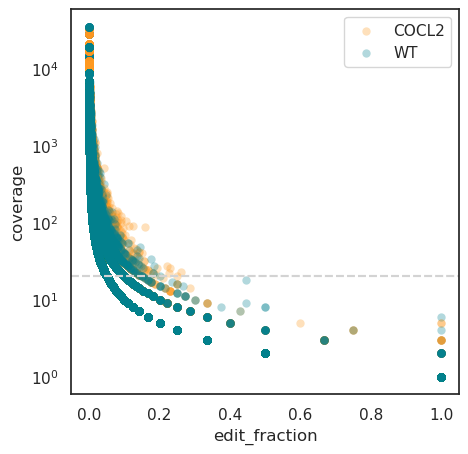

In [33]:
# Visualize Coverage vs. Edit fraction for edited sites found in no treatment and Cocl2 samples after removing common sites and annotated SNPs

for rep in ['rep1', 'rep2']:
    sns.scatterplot(data=all_pos_edits_cocl2_common_removed[rep][~all_pos_edits_cocl2_common_removed[rep]['key'].isin(snps_list)], x='edit_fraction', y='coverage', alpha=0.3, linewidth=0, color='#FE9920')
    sns.scatterplot(data=all_pos_edits_wt_common_removed[rep][~all_pos_edits_wt_common_removed[rep]['key'].isin(snps_list)], x='edit_fraction', y='coverage', alpha=0.3, linewidth=0, color='#028090')
    
    plt.yscale('log')
    plt.legend(['COCL2', 'WT'])
    plt.axhline(y=20, color='lightgrey', linestyle='dashed')
plt.show()

In [34]:
# store edited positions after removing common sites and annotated SNPs
all_pos_edits_wt_common_all_cocl2_snp_removed = {}
all_pos_edits_cocl2_common_all_cocl2_snp_removed = {}
for rep in ['rep1', 'rep2']:
    all_pos_edits_wt_common_all_cocl2_snp_removed[rep] = all_pos_edits_wt_common_removed[rep][~all_pos_edits_wt_common_removed[rep]['key'].isin(snps_list)]
    all_pos_edits_cocl2_common_all_cocl2_snp_removed[rep] = all_pos_edits_cocl2_common_removed[rep][~all_pos_edits_cocl2_common_removed[rep]['key'].isin(snps_list)]

In [35]:
# store sites for no treatment for downstream analysis
keep_edits_wt = {}
for rep in ['rep1', 'rep2']:
    df_wt = all_pos_edits_wt_common_all_cocl2_snp_removed[rep].copy()
    df_wt['gene_id'] = df_wt.apply(lambda x: x[3].split(':')[0], axis=1)
    df_wt['transcript_id'] = df_wt.apply(lambda x: x[3].split(':')[1], axis=1)
    #df_apo = df_apo[df_apo['coverage']>=20]
    keep_edits_wt[rep] = df_wt

In [36]:
# store sites for CoCl2 for downstream analysis
keep_edits_cocl2 = {}
for rep in ['rep1', 'rep2']:
    df_cocl2 = all_pos_edits_cocl2_common_all_cocl2_snp_removed[rep].copy()
    df_cocl2['gene_id'] = df_cocl2.apply(lambda x: x[3].split(':')[0], axis=1)
    df_cocl2['transcript_id'] = df_cocl2.apply(lambda x: x[3].split(':')[1], axis=1)
    #df_rps2 = df_rps2[df_rps2['coverage']>=20]
    keep_edits_cocl2[rep] = df_cocl2

In [37]:
# For comparing mapped reads and mapped edits
mapped_edits = []
for sample_dict in [['NT', sample_dict_wt], ['COCL2',sample_dict_cocl2]]:
    s = sample_dict[0]
    d = sample_dict[1]
    for r in ['rep1', 'rep2']:
        if s=='NT':
            mapped_edits.append([d[r], total_mapped_reads[d[r]], 'mapped reads'])
            mapped_edits.append([d[r], keep_edits_wt[r].shape[0], 'edits'])
        elif s=='COCL2':
            mapped_edits.append([d[r], total_mapped_reads[d[r]], 'mapped reads'])
            mapped_edits.append([d[r], keep_edits_cocl2[r].shape[0], 'edits'])
                                

In [38]:
mapped_edits_df = pd.DataFrame(mapped_edits, columns=['sample', 'counts', 'metric'])

/tmp/ipykernel_1453374/2875945623.py:1: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sns.barplot(data=mapped_edits_df, x='sample', y='counts', hue='metric', palette=custom_palette[2:])


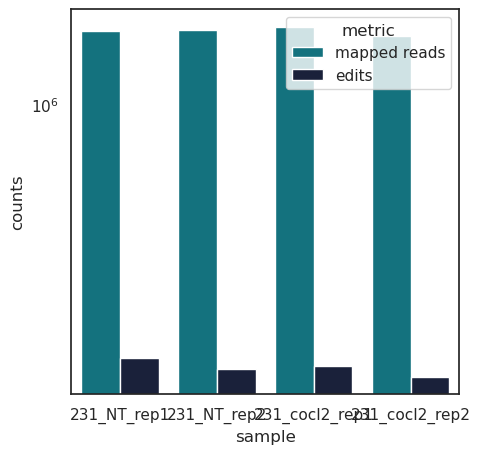

In [39]:
sns.barplot(data=mapped_edits_df, x='sample', y='counts', hue='metric', palette=custom_palette[2:])
plt.yscale('log')

## Calculate EditsC


### Getting Exon and UTRs gene and Transcript (Don't need to re-run unless creating files again')

In [40]:
def gtf_to_bed(gtf_file, bed_file):
    '''generate BED file for exons and UTRs of genes'''
    gtf_df = pd.read_csv(gtf_file, sep='\t', comment='#', header=None,
                     names=['chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'])
    gtf_df = gtf_df[gtf_df['feature'].isin(['exon', 'UTR'])]
    gtf_df['gene_name'] = gtf_df['attribute'].str.extract('gene_id "([^"]+)"')
    bed_df = gtf_df[['chrom', 'start', 'end', 'gene_name', 'score', 'strand']]
    bed_df['start'] = bed_df['start'] - 1
    bed_df.to_csv(bed_file, sep='\t', index=False, header=False)

In [41]:
gtf_file = '/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/refs/hg38/gencode.v38.annotation.gtf'  # Replace with your GTF file path
bed_file = '/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/refs/hg38/output_exons_utrs.genes.bed'
#gtf_to_bed(gtf_file, bed_file) # only run once

In commandline: 

```sort -k1,1 -k2,2n output_exons_utrs.bed > output_exons_utrs.sorted.bed```

```bedtools merge -i output_exons_utrs.genes.sorted.bed -s -c 4,6 -o distinct > merged_exons_utrs.genes.hg19.bed``` 

```bedtools getfasta -fi hg19.fa -bed merged_exons_utrs.genes.hg19.bed -name -s > merged_exons_utrs.genes.hg19.fasta```

In [42]:
def count_cytosines(fasta_file):
    '''Count the cytosines for coordinate groups associated with each gene'''
    cytosine_counts = {}
    for record in SeqIO.parse(fasta_file, "fasta"):
        gene_ids = record.id.split("(")[0].split(',')  # Had to change this for hg38. In hg19 was splitting based on ':'
        sequence = str(record.seq).upper()
        for gene_id in gene_ids:
            if gene_id in cytosine_counts:
                cytosine_counts[gene_id] += sequence.count('C')
            else:
                cytosine_counts[gene_id] = sequence.count('C')
    return cytosine_counts

In [43]:
gene_coordinates_fasta = '/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/refs/hg38/merged_exons_utrs.genes.hg38.fasta'

In [44]:
gene_cytosine_counts = count_cytosines(gene_coordinates_fasta)

In [45]:
def gtf_to_bed_transcript(gtf_file, bed_file):
    '''generate BED file for exons and UTRs of mRNA isoforms'''
    gtf_df = pd.read_csv(gtf_file, sep='\t', comment='#', header=None,
                     names=['chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'])
    gtf_df = gtf_df[gtf_df['feature'].isin(['exon', 'UTR'])]
    gtf_df['transcript_id'] = gtf_df['attribute'].str.extract('transcript_id "([^"]+)"')
    bed_df = gtf_df[['chrom', 'start', 'end', 'transcript_id', 'score', 'strand']]
    bed_df['start'] = bed_df['start'] - 1
    bed_df.to_csv(bed_file, sep='\t', index=False, header=False)

In [46]:
transcript_bed_file = '/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/refs/hg38/output_exons_utrs.transcript.bed'
#gtf_to_bed_transcript(gtf_file, transcript_bed_file) # only run once

In commandline:

```sort -k1,1 -k2,2n output_exons_utrs.transcript.bed > output_exons_utrs.transcript.sorted.bed```

```bedtools merge -i output_exons_utrs.transcript.sorted.bed -s -c 4,6 -o distinct > merged_exons_utrs.transcript.hg19.bed```

```bedtools getfasta -fi hg19.fa -bed merged_exons_utrs.transcript.hg19.bed -name -s > merged_exons_utrs.transcript.hg19.fasta```

In [47]:
def count_cytosines_transcript(fasta_file):
    '''Count the cytosines for coordinate groups associated with each mRNA isoform'''
    cytosine_counts = {}
    for record in SeqIO.parse(fasta_file, "fasta"):
        ids = record.id.split("(")[0].split(',')  # Adjust based on your FASTA header format
        sequence = str(record.seq).upper()
        for transcript in ids:
            if transcript in cytosine_counts:
                cytosine_counts[transcript] += sequence.count('C')
            else:
                cytosine_counts[transcript] = sequence.count('C')
    return cytosine_counts

In [48]:
transcript_coordinates_fasta = '/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/refs/hg38/merged_exons_utrs.transcript.hg38.fasta'

In [49]:
transcript_cytosine_counts = count_cytosines_transcript(transcript_coordinates_fasta)

In [50]:
def calculate_editsC(keep_edits, c_counts):
    '''Calculate the editsC metric for the gene level'''
    gene_editsC = {}
    for rep in ['rep1', 'rep2']:
        edit_count_gene = keep_edits[rep].drop_duplicates(subset=[0,1,2,5, 'gene_id']).groupby('gene_id').count()[[0]]
        edit_count_gene['num_c'] = edit_count_gene.index.map(c_counts)
        edit_count_gene = edit_count_gene.rename(columns={0:'edited_c'})
        edit_count_gene['editsC'] = edit_count_gene['edited_c']/edit_count_gene['num_c']
        gene_editsC[rep] = edit_count_gene
    return gene_editsC

In [51]:
wt_gene_editsC = calculate_editsC(keep_edits_wt, gene_cytosine_counts)

In [52]:
cocl2_gene_editsC = calculate_editsC(keep_edits_cocl2, gene_cytosine_counts)

In [53]:
def calculate_editsC_transcript(keep_edits, c_counts):
    '''Calculate the editsC metric for the mRNA isoform level'''
    transcript_editsC = {}
    for rep in ['rep1', 'rep2']:
        edit_count_transcript = keep_edits[rep].groupby('transcript_id').count()[[0]]
        edit_count_transcript['num_c'] = edit_count_transcript.index.map(c_counts)
        edit_count_transcript = edit_count_transcript.rename(columns={0:'edited_c'})
        edit_count_transcript['editsC'] = edit_count_transcript['edited_c']/edit_count_transcript['num_c']
        transcript_editsC[rep] = edit_count_transcript
    return transcript_editsC

In [54]:
wt_transcript_editsC = calculate_editsC_transcript(keep_edits_wt, transcript_cytosine_counts)
cocl2_transcript_editsC = calculate_editsC_transcript(keep_edits_cocl2, transcript_cytosine_counts)

In [55]:
def make_heatmap(wt_dict, cocl2_dict):
    '''concatenate editsC for replicates and generate a heatmap'''
    editsC_heatmap = pd.DataFrame()
    for sample, d in [('NT', wt_dict), ('COCL2', cocl2_dict)]:
        for rep in ['rep1', 'rep2']:
            d[rep] = d[rep].rename(columns={'editsC' : f'editsC_{sample}_{rep}'})
            editsC_heatmap = pd.concat([editsC_heatmap, d[rep][[f'editsC_{sample}_{rep}']]], axis=1)
    sns.clustermap(editsC_heatmap.dropna(), cmap='cividis')
    plt.show()
    return editsC_heatmap

/tscc/projects/ps-yeolab4/software/miniconda_tscc2/envs/python3essential-1.99.0/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/tscc/projects/ps-yeolab4/software/miniconda_tscc2/envs/python3essential-1.99.0/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


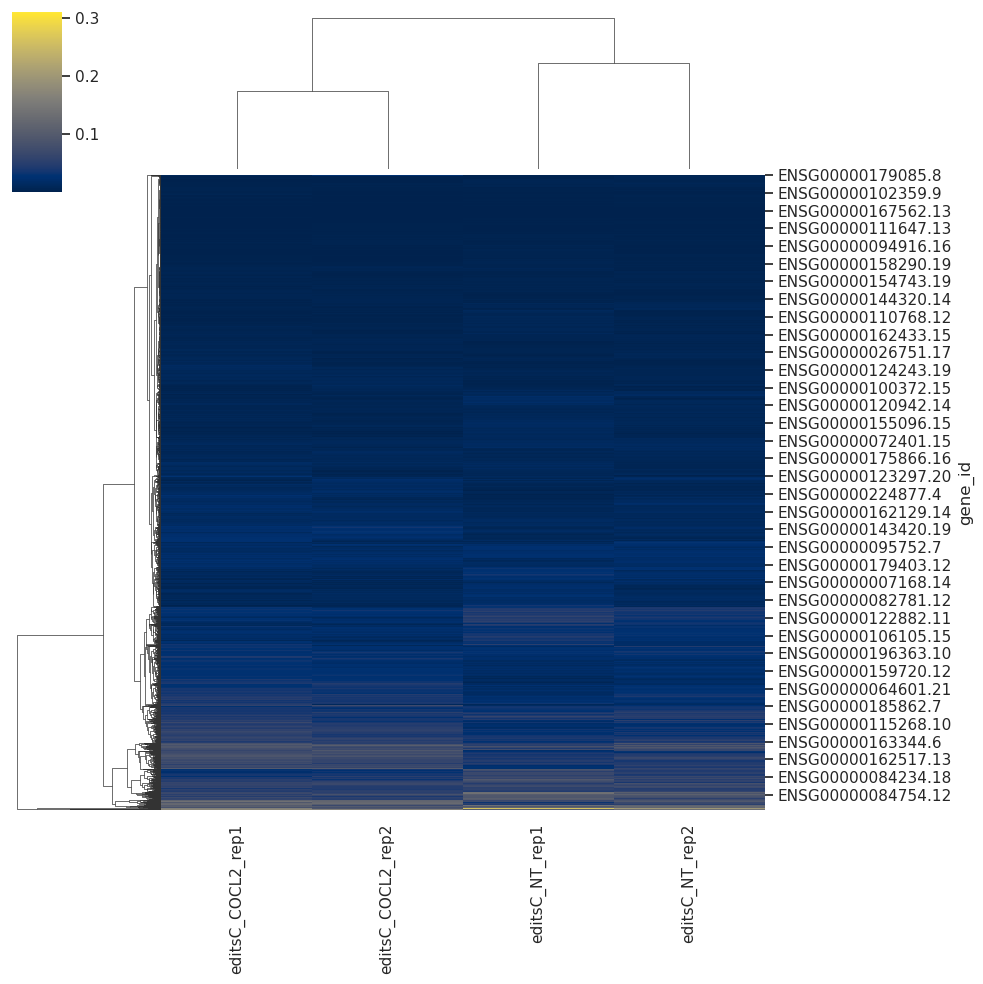

In [56]:
gene_editsC = make_heatmap(wt_gene_editsC, cocl2_gene_editsC)

/tscc/projects/ps-yeolab4/software/miniconda_tscc2/envs/python3essential-1.99.0/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/tscc/projects/ps-yeolab4/software/miniconda_tscc2/envs/python3essential-1.99.0/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


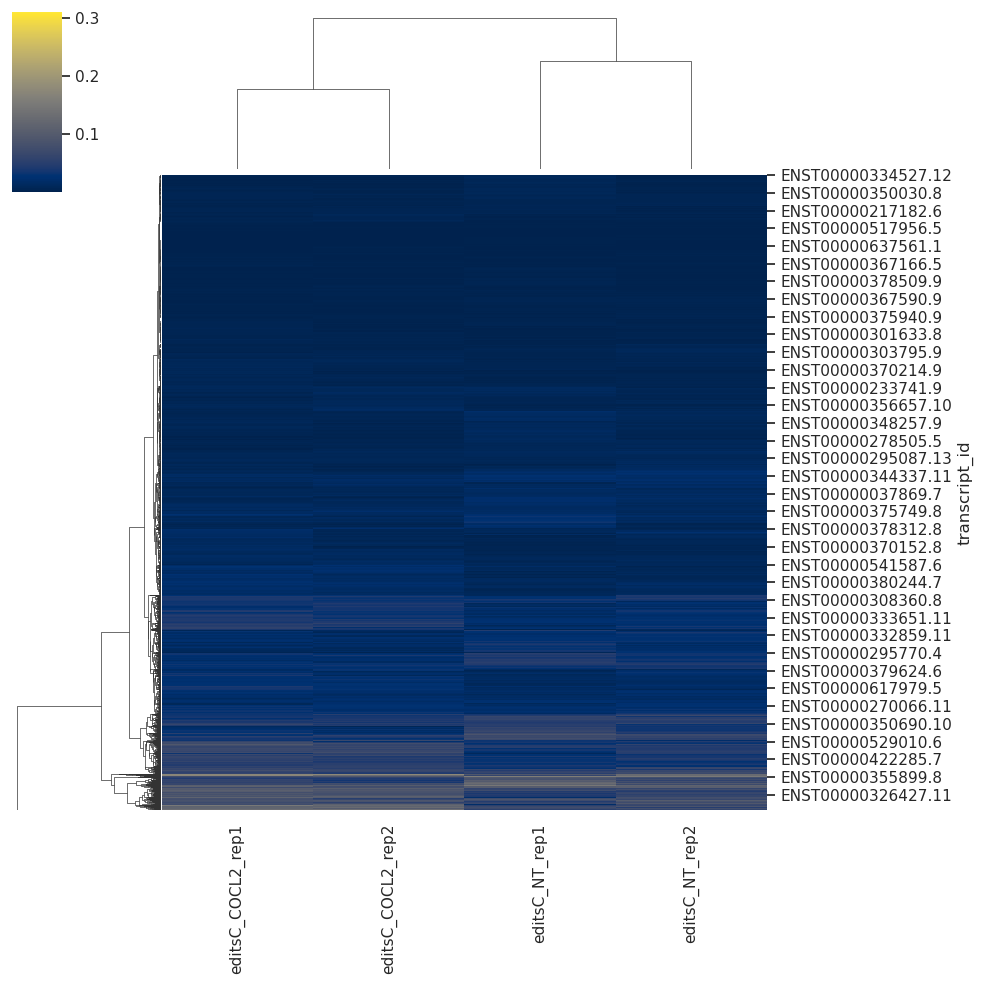

In [57]:
transcript_editsC = make_heatmap(wt_transcript_editsC, cocl2_transcript_editsC)

In [58]:
def parse_gtf(gtf_file_path):
    '''Parse the GTF for information to annotate the gene level EditsC table with'''
    df_gtf = pd.read_csv(gtf_file_path, sep='\t', comment='#', header=None, names=['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'])
    df_gtf = df_gtf[df_gtf['feature'] == 'gene']
    df_gtf['gene_id'] = df_gtf['attribute'].str.extract('gene_id "([^"]+)"')
    df_gtf['gene_name'] = df_gtf['attribute'].str.extract('gene_name "([^"]+)"')
    df_gtf['gene_type'] = df_gtf['attribute'].str.extract('gene_type "([^"]+)"')
    df_genes = df_gtf[['gene_id', 'gene_name', 'gene_type']].set_index('gene_id')

    return df_genes

def annotate_dataframe(gene_editsC_df, gtf_file_path):
    '''Add the annotation to the gene level EditsC table'''
    df_genes_annotations = parse_gtf(gtf_file_path)
    annotated_df = gene_editsC_df.merge(df_genes_annotations, left_index=True, right_index=True, how='left')

    return annotated_df

In [59]:
def parse_gtf_for_transcripts(gtf_file_path):
    '''Parse the GTF for information to annotate the mRNA isoform level EditsC table with'''
    df_gtf = pd.read_csv(gtf_file_path, sep='\t', comment='#', header=None,names=['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'])
    df_gtf = df_gtf[df_gtf['feature'] == 'transcript']
    df_gtf['transcript_id'] = df_gtf['attribute'].str.extract('transcript_id "([^"]+)"')
    df_gtf['gene_name'] = df_gtf['attribute'].str.extract('gene_name "([^"]+)"')
    df_gtf['transcript_type'] = df_gtf['attribute'].str.extract('transcript_type "([^"]+)"')
    df_transcripts = df_gtf[['transcript_id', 'gene_name', 'transcript_type']].set_index('transcript_id')

    return df_transcripts

def annotate_dataframe_with_transcript_info(transcript_editsC_df, gtf_file_path):
    '''Add the annotation to the mRNA isoform level EditsC table'''
    # Parse the GTF file for transcripts
    df_transcripts = parse_gtf_for_transcripts(gtf_file_path)

    # Merge with the existing DataFrame
    annotated_df = transcript_editsC_df.merge(df_transcripts, left_index=True, right_index=True, how='left')

    return annotated_df

In [61]:
def calculate_mean_wt(data):
    '''calculate the average EditsC for all replicates of no treatment'''
    return np.mean([data['editsC_NT_rep1'], data['editsC_NT_rep2']])

def calculate_mean_cocl2(data):
    '''calculate the average EditsC for all replicates of CoCl2'''
    return np.mean([data['editsC_COCL2_rep1'], data['editsC_COCL2_rep2']])

In [62]:
annotated_gene_editsC = annotate_dataframe(gene_editsC, gtf_file)

In [63]:
annotated_gene_editsC['ensembl_gene_id'] = annotated_gene_editsC.apply(lambda x: x.name.split('.')[0], axis=1)

In [65]:
annotated_gene_editsC = pd.concat([annotated_gene_editsC, pd.read_csv('/tscc/nfs//home/pjaganna1/projects/STAMP/stamp_v3_pipeline/notebooks/231_data/231_WT_vs_Cocl2_gene.csv', index_col=0)], axis=1)

In [67]:
annotated_gene_editsC_copy = annotated_gene_editsC.copy()

In [68]:
# Add gene counts to EditsC data frame
for key in gene_counts:
    annotated_gene_editsC_copy = pd.concat([annotated_gene_editsC_copy, gene_counts[key].set_index('Geneid')], axis=1)

In [73]:
def add_zero_edits(df, metric):
    '''Account for genes that are expressed and have reads but are not edited'''
    if metric =='editsC':
        for rep in ['1', '2']:
            df.loc[~df[f'231_NT_rep{rep}'].isna() & df[f'editsC_NT_rep{rep}'].isna(), f'editsC_NT_rep{rep}'] = 0
            df.loc[~df[f'231_cocl2_rep{rep}'].isna()& df[f'editsC_COCL2_rep{rep}'].isna(), f'editsC_COCL2_rep{rep}'] = 0
    return df

In [74]:
annotated_gene_editsC_copy=add_zero_edits(annotated_gene_editsC_copy, 'editsC')

In [75]:
annotated_gene_editsC_copy['NT_mean'] = annotated_gene_editsC_copy.apply(calculate_mean_wt, axis=1)
annotated_gene_editsC_copy['COCL2_mean'] = annotated_gene_editsC_copy.apply(calculate_mean_cocl2, axis=1)

### Replicate Correlation

In [80]:
from scipy import stats

PearsonRResult(statistic=0.8717270887305016, pvalue=0.0)


Text(0.25, 0.2, '0.8717270887305016')

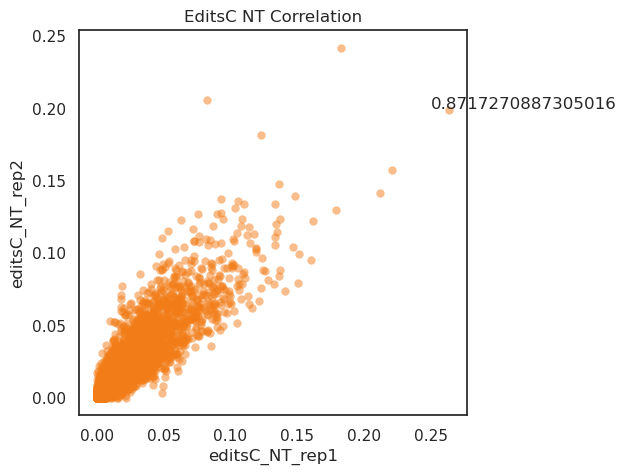

In [81]:
sns.scatterplot(data=annotated_gene_editsC_copy, x='editsC_NT_rep1', y='editsC_NT_rep2', linewidth=0, alpha=0.5, color=custom_palette[5])
plt.title('EditsC NT Correlation')
print(stats.pearsonr(annotated_gene_editsC_copy.dropna()['editsC_NT_rep1'], annotated_gene_editsC_copy.dropna()['editsC_NT_rep2']))
plt.text(0.25, 0.2, stats.pearsonr(annotated_gene_editsC_copy.dropna()['editsC_NT_rep1'], annotated_gene_editsC_copy.dropna()['editsC_NT_rep2'])[0])

PearsonRResult(statistic=0.949859894582376, pvalue=0.0)


Text(0.25, 0.2, '0.949859894582376')

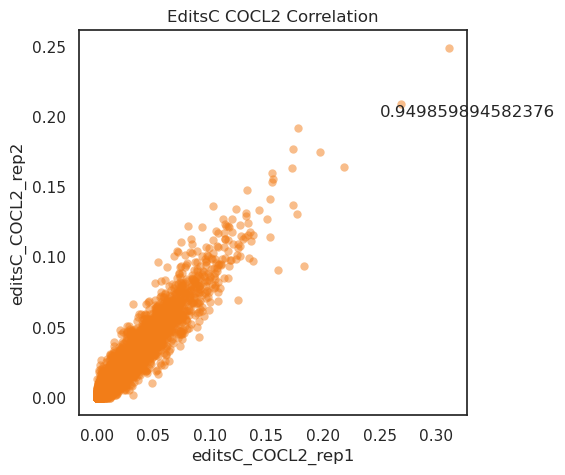

In [82]:
sns.scatterplot(data=annotated_gene_editsC_copy, x='editsC_COCL2_rep1', y='editsC_COCL2_rep2', linewidth=0, alpha=0.5, color=custom_palette[5])
plt.title('EditsC COCL2 Correlation')
print(stats.pearsonr(annotated_gene_editsC_copy.dropna()['editsC_COCL2_rep1'], annotated_gene_editsC_copy.dropna()['editsC_COCL2_rep2']))
plt.text(0.25, 0.2, stats.pearsonr(annotated_gene_editsC_copy.dropna()['editsC_COCL2_rep1'], annotated_gene_editsC_copy.dropna()['editsC_COCL2_rep2'])[0])

In [84]:
from scipy.stats import pearsonr, spearmanr

In [85]:
annotated_gene_editsC_copy['NT_RPKM_mean'] = annotated_gene_editsC_copy.apply(lambda x: np.mean([x['231_NT_rep1_RPKM'], x['231_NT_rep2_RPKM']]), axis=1)
annotated_gene_editsC_copy['COCL2_RPKM_mean']= annotated_gene_editsC_copy.apply(lambda x: np.mean([x['231_cocl2_rep1_RPKM'], x['231_cocl2_rep2_RPKM']]), axis=1)

In [86]:
from scipy.stats import ttest_ind

In [87]:
annotated_gene_editsC_copy_2 = annotated_gene_editsC_copy.copy()

In [88]:
annotated_gene_editsC_copy_2 = annotated_gene_editsC_copy_2.dropna()

In [89]:
annotated_gene_editsC_copy_2.shape

(4384, 29)

In [90]:
# setting coverage threshold
annotated_gene_editsC_copy_2 = annotated_gene_editsC_copy_2[(annotated_gene_editsC_copy_2['231_cocl2_rep1']>=10) & (annotated_gene_editsC_copy_2['231_cocl2_rep2']>=10) & (annotated_gene_editsC_copy_2['231_NT_rep1']>=10) & (annotated_gene_editsC_copy_2['231_NT_rep2']>=10)]

In [91]:
annotated_gene_editsC_copy_2['edit_FC'] = (annotated_gene_editsC_copy_2['COCL2_mean'])/(annotated_gene_editsC_copy_2['NT_mean'])

In [92]:
annotated_gene_editsC_copy_2['edit_logFC'] = np.log2(annotated_gene_editsC_copy_2['edit_FC'])

/tscc/projects/ps-yeolab4/software/miniconda_tscc2/envs/python3essential-1.99.0/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [93]:
# removing FC calculations with 0 in the denominator
annotated_gene_editsC_copy_2_filtered = annotated_gene_editsC_copy_2[(annotated_gene_editsC_copy_2['edit_logFC'] != float('inf')) & (annotated_gene_editsC_copy_2['edit_logFC'] != -float('inf'))].sort_values(by=('edit_logFC'), ascending=False)#[annotated_gene_editsC_copy_2['gene_name'].isin(sr_data['gene_name'])]

/tmp/ipykernel_1453374/1123377190.py:4: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.boxplot(annotated_gene_editsC_copy[['NT_mean', 'COCL2_mean']].dropna(), palette=custom_palette)


<Axes: >

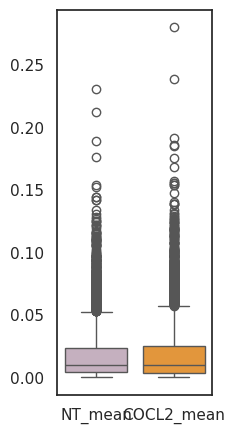

In [94]:
# Global changes in translation
sns.set(rc={'figure.figsize':(2,5)})
sns.set_style('white')
sns.boxplot(annotated_gene_editsC_copy[['NT_mean', 'COCL2_mean']].dropna(), palette=custom_palette)

In [95]:
# Calculating Wilcoxon rank sum for global change in translation
stats.ranksums(annotated_gene_editsC_copy.dropna()['NT_mean'],annotated_gene_editsC_copy.dropna()['COCL2_mean'] )

RanksumsResult(statistic=-1.6416042376303273, pvalue=0.10067204888933429)

SignificanceResult(statistic=nan, pvalue=nan)
SignificanceResult(statistic=0.8469645080176333, pvalue=0.0)


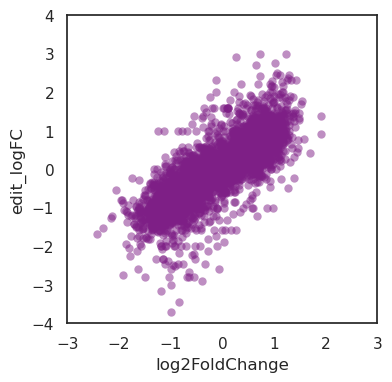

In [98]:
# Correlation between changes in gene-level transcription and translation
sns.set(rc={'figure.figsize':(4,4)})
sns.set_style('white')
sns.scatterplot(data=annotated_gene_editsC_copy_2.dropna(), x='log2FoldChange', y='edit_logFC', alpha=0.5, linewidth=0, color='#7E1F86')
print(stats.spearmanr(annotated_gene_editsC_copy_2.dropna()['log2FoldChange'], annotated_gene_editsC_copy_2.dropna()['edit_logFC']))
plt.xlim(-3, 3)
plt.ylim(-4,4)
print(stats.spearmanr(annotated_gene_editsC_copy_2[(np.abs(annotated_gene_editsC_copy_2['log2FoldChange'])!= float('inf')) & (np.abs(annotated_gene_editsC_copy_2['edit_logFC'])!= float('inf'))]['log2FoldChange'], annotated_gene_editsC_copy_2[(np.abs(annotated_gene_editsC_copy_2['log2FoldChange'])!= float('inf')) & (np.abs(annotated_gene_editsC_copy_2['edit_logFC'])!= float('inf'))]['edit_logFC']))

In [99]:
# Add DESeq2 results to isoform EditsC table
deseq2_transcript = pd.read_csv('~/projects/STAMP/stamp_v3_pipeline/notebooks/231_data/231_WT_vs_Cocl2_transcript.csv', index_col=0)

In [100]:
annotated_transcript_editsC= annotate_dataframe_with_transcript_info(transcript_editsC, gtf_file)

In [101]:
for key in transcript_counts:
    annotated_transcript_editsC = pd.concat([annotated_transcript_editsC, transcript_counts[key]], axis=1)

In [103]:
annotated_transcript_editsC = annotated_transcript_editsC.merge(deseq2_transcript, left_index=True, right_index=True)

In [104]:
def add_zero_edits_transcript(df):
    '''Account for isoforms that are expressed and have reads but are not edited'''
    for rep in ['1', '2']:
        df.loc[~df[f'231_NT_rep{rep}_count'].isna() & df[f'editsC_NT_rep{rep}'].isna(), f'editsC_NT_rep{rep}'] = 0
        df.loc[~df[f'231_cocl2_rep{rep}_count'].isna()& df[f'editsC_COCL2_rep{rep}'].isna(), f'editsC_COCL2_rep{rep}'] = 0
        
    return df

In [105]:
annotated_transcript_editsC['NT_mean'] = annotated_transcript_editsC.apply(calculate_mean_wt, axis=1)

In [106]:
annotated_transcript_editsC['COCL2_mean'] = annotated_transcript_editsC.apply(calculate_mean_cocl2, axis=1)

In [107]:
annotated_transcript_editsC['shortened_transcript_id'] = annotated_transcript_editsC.apply(lambda x: x.name.split('.')[0], axis=1)

In [108]:
annotated_transcript_editsC['NT_RPKM_mean'] = annotated_transcript_editsC.apply(lambda x: np.mean([x['231_NT_rep1_RPKM'], x['231_NT_rep2_RPKM']]), axis=1)
annotated_transcript_editsC['COCL2_RPKM_mean']= annotated_transcript_editsC.apply(lambda x: np.mean([x['231_cocl2_rep1_RPKM'], x['231_cocl2_rep2_RPKM']]), axis=1)

In [110]:
annotated_transcript_editsC_copy = annotated_transcript_editsC.dropna().copy()

In [111]:
annotated_transcript_editsC_copy['edit_FC'] = annotated_transcript_editsC_copy['COCL2_mean']/annotated_transcript_editsC_copy['NT_mean']

In [113]:
# removing divide by zeros
annotated_transcript_editsC_copy = annotated_transcript_editsC_copy[np.abs(annotated_transcript_editsC_copy['edit_FC']) != float('inf')]

In [114]:
annotated_transcript_editsC_copy['edit_logFC'] = np.log2(annotated_transcript_editsC_copy['edit_FC'])

In [115]:
annotated_transcript_editsC_copy = annotated_transcript_editsC_copy[np.abs(annotated_transcript_editsC_copy['edit_logFC']) != float('inf')]

In [116]:
annotated_transcript_editsC_copy['ttest_pval'] = annotated_transcript_editsC_copy.apply(lambda x: stats.ttest_ind([x['editsC_NT_rep1'], x['editsC_NT_rep1']], [x['editsC_COCL2_rep1'], x['editsC_COCL2_rep2']])[1], axis=1)

/tscc/projects/ps-yeolab4/software/miniconda_tscc2/envs/python3essential-1.99.0/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [117]:
annotated_transcript_editsC_copy = annotated_transcript_editsC_copy.sort_values(by='edit_logFC', ascending=False)

SignificanceResult(statistic=0.8359985968895614, pvalue=0.0)


(-4.0, 4.0)

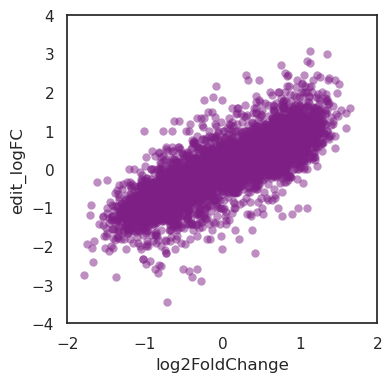

In [118]:
# Correlation between changes in transcription and translation at isoform level
sns.set(rc={'figure.figsize':(4,4)})
sns.set_style('white')
sns.scatterplot(data=annotated_transcript_editsC_copy, x='log2FoldChange', y='edit_logFC', alpha=0.5, linewidth=0, color='#7E1F86')
print(stats.spearmanr(annotated_transcript_editsC_copy['log2FoldChange'], annotated_transcript_editsC_copy['edit_logFC']))
plt.xlim(-2, 2)
plt.ylim(-4,4)

### EditsC by sequence characteristics

In [121]:
# Loadingin file with all 5'UTRs annotated with whether they have HRE or not
five_UTR_hre_seq_annotation = pd.read_csv('/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/notebooks/231_data/5UTR_gtf_seq_hre_annotation.txt', sep='\t')

In [122]:
hre_transcripts = five_UTR_hre_seq_annotation[five_UTR_hre_seq_annotation['five_hre_motif']==True]['transcript_id'].to_list()

In [123]:
five_hre_present_transcripts  =  annotated_transcript_editsC_copy[annotated_transcript_editsC_copy.index.isin(hre_transcripts)]

In [124]:
five_hre_present_transcripts['delta_EditsC'] = five_hre_present_transcripts.apply(lambda x: x['COCL2_mean'] - x['NT_mean'], axis=1)

/tmp/ipykernel_1453374/3869707784.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_hre_present_transcripts['delta_EditsC'] = five_hre_present_transcripts.apply(lambda x: x['COCL2_mean'] - x['NT_mean'], axis=1)


RanksumsResult(statistic=-0.08887756713130786, pvalue=0.9291792118212592)


/tmp/ipykernel_1453374/4246941333.py:10: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.boxplot(data=pd.concat([five_hre_present_nt, five_hre_present_cocl2]), x='condition',y='mean', hue='condition', palette=custom_palette)


Text(COCL2, 0.12452107279693486, 'MIF-201')

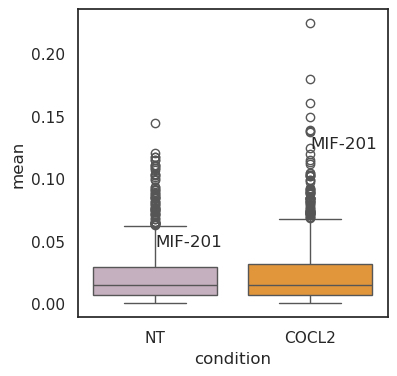

In [128]:
five_hre_present_nt = annotated_transcript_editsC_copy[annotated_transcript_editsC_copy.index.isin(hre_transcripts)][['NT_mean']]
five_hre_present_nt['condition'] = 'NT'
five_hre_present_nt = five_hre_present_nt.rename(columns={'NT_mean':'mean'})
five_hre_present_cocl2 = annotated_transcript_editsC_copy[annotated_transcript_editsC_copy.index.isin(hre_transcripts)][['COCL2_mean']]
five_hre_present_cocl2['condition'] = 'COCL2'
five_hre_present_cocl2 = five_hre_present_cocl2.rename(columns={'COCL2_mean':'mean'})
print(stats.ranksums(five_hre_present_nt['mean'], five_hre_present_cocl2['mean']))


sns.boxplot(data=pd.concat([five_hre_present_nt, five_hre_present_cocl2]), x='condition',y='mean', hue='condition', palette=custom_palette)
plt.text('NT', five_hre_present_transcripts.loc['ENST00000215754.8', 'NT_mean'], 'MIF-201')
plt.text('COCL2', five_hre_present_transcripts.loc['ENST00000215754.8', 'COCL2_mean'], 'MIF-201')


In [130]:
five_UTR_seq_annotation = pd.read_csv('/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/notebooks/231_data/5UTR_gtf_seq_annotation.txt', sep='\t')

In [131]:
five_UTR_seq_top_present = set(five_UTR_seq_annotation[five_UTR_seq_annotation['five_top_motif']==True]['transcript_id'].tolist())

In [132]:
five_UTR_seq_top_absent = set(five_UTR_seq_annotation[five_UTR_seq_annotation['five_top_motif']==False]['transcript_id'].tolist())

In [134]:
five_top_present_transcripts= annotated_transcript_editsC_copy[annotated_transcript_editsC_copy.index.isin(five_UTR_seq_top_present)]

In [135]:
five_top_present_transcripts['delta_EditsC'] = five_top_present_transcripts.apply(lambda x: x['COCL2_mean'] - x['NT_mean'], axis=1)

/tmp/ipykernel_1453374/114568480.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  five_top_present_transcripts['delta_EditsC'] = five_top_present_transcripts.apply(lambda x: x['COCL2_mean'] - x['NT_mean'], axis=1)


RanksumsResult(statistic=-1.461237168595889, pvalue=0.14395036605835096)
RanksumsResult(statistic=-1.469511049631156, pvalue=0.14169422700265782)


/tmp/ipykernel_1453374/3813293472.py:19: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.boxplot(data=pd.concat([five_top_present_nt, five_top_present_cocl2]), x='condition',y='mean', hue='condition', ax=axes[0], palette=custom_palette)
/tmp/ipykernel_1453374/3813293472.py:20: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.boxplot(data=pd.concat([five_top_absent_nt, five_top_absent_cocl2]), x='condition', y='mean', hue='condition', ax=axes[1], palette=custom_palette)


Text(COCL2, 0.118491921005386, 'HSP90AB1-203')

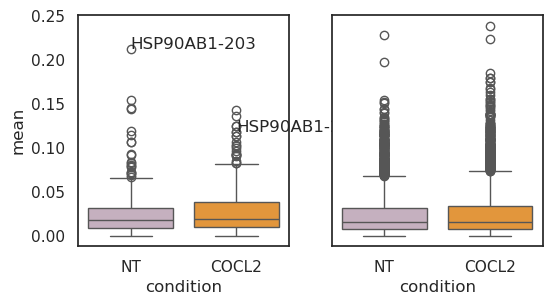

In [136]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)

five_top_present_nt = annotated_transcript_editsC_copy[annotated_transcript_editsC_copy.index.isin(five_UTR_seq_top_present)][['NT_mean']]
five_top_present_nt['condition'] = 'NT'
five_top_present_nt = five_top_present_nt.rename(columns={'NT_mean':'mean'})
five_top_present_cocl2 = annotated_transcript_editsC_copy[annotated_transcript_editsC_copy.index.isin(five_UTR_seq_top_present)][['COCL2_mean']]
five_top_present_cocl2['condition'] = 'COCL2'
five_top_present_cocl2 = five_top_present_cocl2.rename(columns={'COCL2_mean':'mean'})
print(stats.ranksums(five_top_present_nt['mean'], five_top_present_cocl2['mean']))

five_top_absent_nt = annotated_transcript_editsC_copy[annotated_transcript_editsC_copy.index.isin(five_UTR_seq_top_absent)][['NT_mean']]
five_top_absent_nt['condition'] = 'NT'
five_top_absent_nt = five_top_absent_nt.rename(columns={'NT_mean':'mean'})
five_top_absent_cocl2 = annotated_transcript_editsC_copy[annotated_transcript_editsC_copy.index.isin(five_UTR_seq_top_absent)][['COCL2_mean']]
five_top_absent_cocl2['condition'] = 'COCL2'
five_top_absent_cocl2 = five_top_absent_cocl2.rename(columns={'COCL2_mean':'mean'})
print(stats.ranksums(five_top_absent_nt['mean'], five_top_absent_cocl2['mean']))

sns.boxplot(data=pd.concat([five_top_present_nt, five_top_present_cocl2]), x='condition',y='mean', hue='condition', ax=axes[0], palette=custom_palette)
sns.boxplot(data=pd.concat([five_top_absent_nt, five_top_absent_cocl2]), x='condition', y='mean', hue='condition', ax=axes[1], palette=custom_palette)
axes[0].text('NT', five_top_present_transcripts.loc['ENST00000371646.10', 'NT_mean'], 'HSP90AB1-203')
axes[0].text('COCL2', five_top_present_transcripts.loc['ENST00000371646.10', 'COCL2_mean'], 'HSP90AB1-203')

### Looking at genes with multiple isoforms expressed and translated

In [137]:
transcripts_per_gene_df = pd.DataFrame(annotated_transcript_editsC_copy.dropna()['gene_name'].value_counts())

In [139]:
# genes having multiple isoforms represented in the dataset
multiple_genes_list = transcripts_per_gene_df[transcripts_per_gene_df['count']>1].index.tolist()

In [140]:
multiple_transcript_genes_df = annotated_transcript_editsC_copy[annotated_transcript_editsC_copy['gene_name'].isin(multiple_genes_list)].dropna()

In [141]:
import itertools

In [142]:
tfs_df = pd.DataFrame()
for gene in set(multiple_transcript_genes_df['gene_name'].tolist()):
    tmp_df = multiple_transcript_genes_df[multiple_transcript_genes_df.gene_name==gene]
    all_ts = list(itertools.combinations(tmp_df.index.tolist(), 2))
    count = 0
    for pair in all_ts:
        t1_df = tmp_df[tmp_df.index==pair[0]][['gene_name', 'editsC_NT_rep1', 'editsC_NT_rep2', 'editsC_COCL2_rep1', 'editsC_COCL2_rep2', 'NT_mean', 'COCL2_mean', 'edit_FC', 'edit_logFC', 'log2FoldChange', 'padj']]
        t2_df = tmp_df[tmp_df.index==pair[1]][['gene_name','editsC_NT_rep1', 'editsC_NT_rep2', 'editsC_COCL2_rep1', 'editsC_COCL2_rep2', 'NT_mean', 'COCL2_mean','edit_FC', 'edit_logFC', 'log2FoldChange', 'padj']]
        pair_df = t1_df.reset_index().merge(t2_df.reset_index(), on='gene_name', suffixes=['_A', '_B'])
        pair_df['label'] = f"{gene}_{count}"
        tfs_df = pd.concat([tfs_df, pair_df])
        count +=1
        

In [143]:
tfs_df_toplot = tfs_df.sort_values('gene_name').set_index('label')[['editsC_NT_rep1_A', 'editsC_NT_rep2_A', 'editsC_COCL2_rep1_A', 'editsC_COCL2_rep2_A','editsC_NT_rep1_B', 'editsC_NT_rep2_B', 'editsC_COCL2_rep1_B', 'editsC_COCL2_rep2_B']]

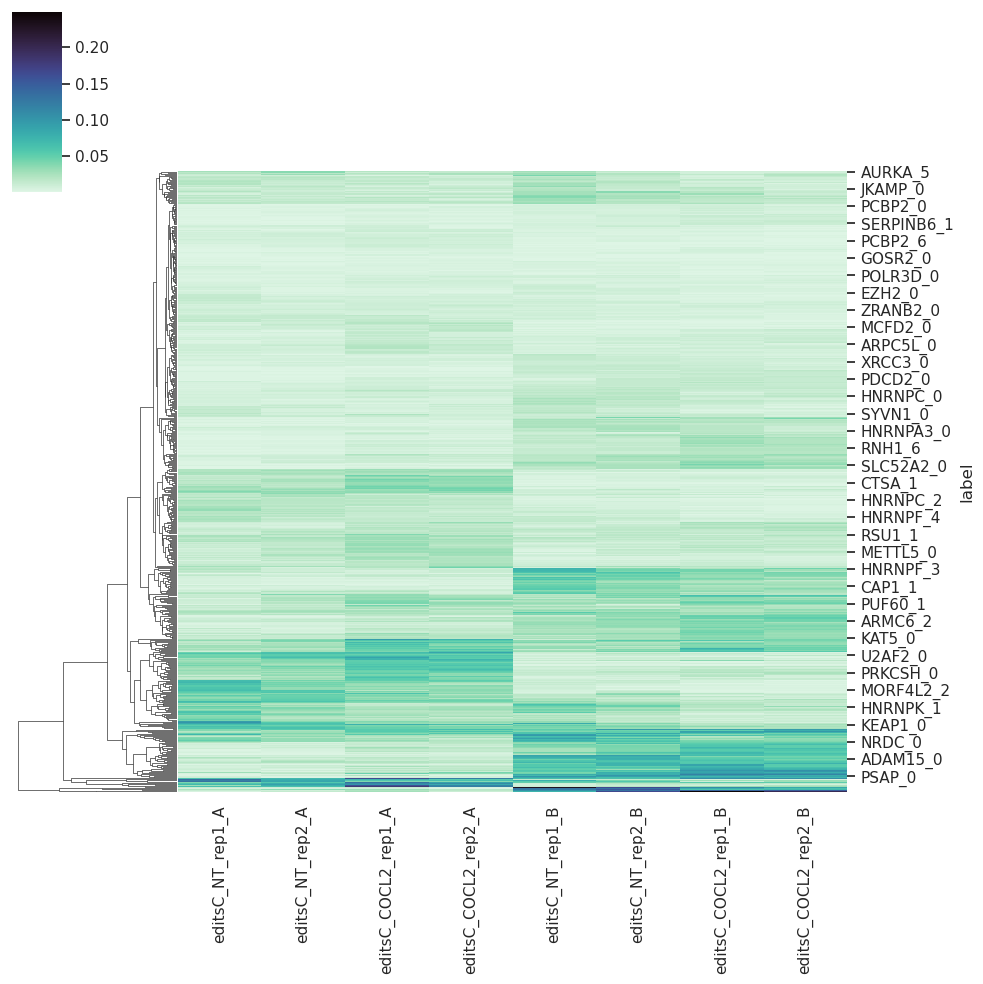

In [145]:
# EditsC for pairs of isoforms of a gene
sns.clustermap(tfs_df_toplot, col_cluster = False, cmap='mako_r')

## Alternative Splicing and EditsC

In [148]:
# Loading results from IsoformSwitchAnalyzeR
isoswitch_r = pd.read_csv('/tscc/nfs/home/pjaganna1/projects/STAMP/stamp_v3_pipeline/notebooks/231_data/diffsplice/IsoSwitch_AS_out.txt', sep='\t').set_index('isoform_id')

In [150]:
# merge IsoformSwitchAnalyzeR results with EditsC table
isoswitch_editsC_merge = annotated_transcript_editsC_copy.merge(isoswitch_r, right_index=True, left_index=True)

In [151]:
isoswitch_editsC_merge_copy = isoswitch_editsC_merge.copy()

In [152]:
isoswitch_editsC_merge_copy['hsp_annot'] = isoswitch_editsC_merge_copy['gene_name_x'].isin(['GRK6'])#['HSP90B1'])#, 'PCMT1'])

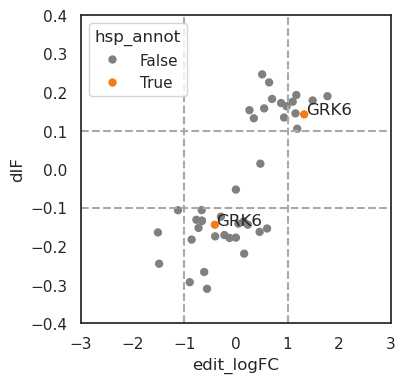

In [158]:
sns.scatterplot(data=isoswitch_editsC_merge_copy[['gene_name_x','edit_logFC', 'dIF','hsp_annot']], x='edit_logFC', y='dIF', hue='hsp_annot', palette=['grey', '#F27D18'], linewidth=0)
plt.xlim(-3, 3)
plt.ylim(-0.4, 0.4)
#plt.axhline(0, linestyle='dashed', color='lightgrey')
plt.axhline(0.1, linestyle='dashed', color='darkgrey')
plt.axhline(-0.1, linestyle='dashed', color='darkgrey')

#plt.axvline(0, linestyle='dashed', color='lightgrey')
plt.axvline(1, linestyle='dashed', color='darkgrey')
plt.axvline(-1, linestyle='dashed', color='darkgrey')
for i, point in isoswitch_editsC_merge_copy[isoswitch_editsC_merge_copy['hsp_annot']==True].iterrows():
        plt.text(point['edit_logFC']+.03, point['dIF'], str(point['gene_name_x']))